Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import time

from tensorflow.keras import layers
from tensorflow.keras import models
import cv2

from matplotlib.collections import LineCollection
import matplotlib.patches as patches

from IPython.display import HTML, display

Declaring relevant constants

In [35]:


# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    "nose": 0,
    "left_eye": 1,
    "right_eye": 2,
    "left_ear": 3,
    "right_ear": 4,
    "left_shoulder": 5,
    "right_shoulder": 6,
    "left_elbow": 7,
    "right_elbow": 8,
    "left_wrist": 9,
    "right_wrist": 10,
    "left_hip": 11,
    "right_hip": 12,
    "left_knee": 13,
    "right_knee": 14,
    "left_ankle": 15,
    "right_ankle": 16,
}

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): "m",
    (0, 2): "c",
    (1, 3): "m",
    (2, 4): "c",
    (0, 5): "m",
    (0, 6): "c",
    (5, 7): "m",
    (7, 9): "m",
    (6, 8): "c",
    (8, 10): "c",
    (5, 6): "y",
    (5, 11): "m",
    (6, 12): "c",
    (11, 12): "y",
    (11, 13): "m",
    (13, 15): "m",
    (12, 14): "c",
    (14, 16): "c",
}


def _keypoints_and_edges_for_display(
    keypoints_with_scores, height, width, keypoint_threshold=0.11
):
    """Returns high confidence keypoints and edges for visualization.

    Args:
      keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
        the keypoint coordinates and scores returned from the MoveNet model.
      height: height of the image in pixels.
      width: width of the image in pixels.
      keypoint_threshold: minimum confidence score for a keypoint to be
        visualized.

    Returns:
      A (keypoints_xy, edges_xy, edge_colors) containing:
        * the coordinates of all keypoints of all detected entities;
        * the coordinates of all skeleton edges of all detected entities;
        * the colors in which the edges should be plotted.
    """
    keypoints_all = []
    keypoint_edges_all = []
    edge_colors = []
    num_instances, _, _, _ = keypoints_with_scores.shape
    for idx in range(num_instances):
        kpts_x = keypoints_with_scores[0, idx, :, 1]
        kpts_y = keypoints_with_scores[0, idx, :, 0]
        kpts_scores = keypoints_with_scores[0, idx, :, 2]
        kpts_absolute_xy = np.stack(
            [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1
        )
        kpts_above_thresh_absolute = kpts_absolute_xy[
            kpts_scores > keypoint_threshold, :
        ]
        keypoints_all.append(kpts_above_thresh_absolute)

        for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
            if (
                kpts_scores[edge_pair[0]] > keypoint_threshold
                and kpts_scores[edge_pair[1]] > keypoint_threshold
            ):
                x_start = kpts_absolute_xy[edge_pair[0], 0]
                y_start = kpts_absolute_xy[edge_pair[0], 1]
                x_end = kpts_absolute_xy[edge_pair[1], 0]
                y_end = kpts_absolute_xy[edge_pair[1], 1]
                line_seg = np.array([[x_start, y_start], [x_end, y_end]])
                keypoint_edges_all.append(line_seg)
                edge_colors.append(color)
    if keypoints_all:
        keypoints_xy = np.concatenate(keypoints_all, axis=0)
    else:
        keypoints_xy = np.zeros((0, 17, 2))

    if keypoint_edges_all:
        edges_xy = np.stack(keypoint_edges_all, axis=0)
    else:
        edges_xy = np.zeros((0, 2, 2))
    return keypoints_xy, edges_xy, edge_colors


def draw_prediction_on_image(
    image,
    keypoints_with_scores,
    crop_region=None,
    close_figure=False,
    output_image_height=None,
):
    """Draws the keypoint predictions on image.

    Args:
      image: A numpy array with shape [height, width, channel] representing the
        pixel values of the input image.
      keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
        the keypoint coordinates and scores returned from the MoveNet model.
      crop_region: A dictionary that defines the coordinates of the bounding box
        of the crop region in normalized coordinates (see the init_crop_region
        function below for more detail). If provided, this function will also
        draw the bounding box on the image.
      output_image_height: An integer indicating the height of the output image.
        Note that the image aspect ratio will be the same as the input image.

    Returns:
      A numpy array with shape [out_height, out_width, channel] representing the
      image overlaid with keypoint predictions.
    """
    height, width, channel = image.shape
    aspect_ratio = float(width) / height
    fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
    # To remove the huge white borders
    fig.tight_layout(pad=0)
    ax.margins(0)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.axis("off")

    im = ax.imshow(image)
    line_segments = LineCollection([], linewidths=(10), linestyle="solid")
    ax.add_collection(line_segments)
    # Turn off tick labels
    scat = ax.scatter([], [], s=60, color="#FF1493", zorder=3)

    (keypoint_locs, keypoint_edges, edge_colors) = _keypoints_and_edges_for_display(
        keypoints_with_scores, height, width
    )

    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
    if keypoint_edges.shape[0]:
        line_segments.set_segments(keypoint_edges)
        line_segments.set_color(edge_colors)
    if keypoint_locs.shape[0]:
        scat.set_offsets(keypoint_locs)

    if crop_region is not None:
        xmin = max(crop_region["x_min"] * width, 0.0)
        ymin = max(crop_region["y_min"] * height, 0.0)
        rec_width = min(crop_region["x_max"], 0.99) * width - xmin
        rec_height = min(crop_region["y_max"], 0.99) * height - ymin
        rect = patches.Rectangle(
            (xmin, ymin),
            rec_width,
            rec_height,
            linewidth=1,
            edgecolor="b",
            facecolor="none",
        )
        ax.add_patch(rect)

    fig.canvas.draw()
    image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    image_from_plot = image_from_plot.reshape(
        fig.canvas.get_width_height()[::-1] + (3,)
    )
    plt.close(fig)
    if output_image_height is not None:
        output_image_width = int(output_image_height / height * width)
        image_from_plot = cv2.resize(
            image_from_plot,
            dsize=(output_image_width, output_image_height),
            interpolation=cv2.INTER_CUBIC,
        )
    return image_from_plot



In [3]:
model_name = "movenet_lightning"
if "movenet_lightning" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
    input_size = 192
elif "movenet_thunder" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
    input_size = 256
else:
    raise ValueError("Unsupported model name: %s" % model_name)

def movenet(input_image, module):


    model = module.signatures['serving_default']

    # SavedModel format expects tensor type of int32.
    input_image = tf.cast(input_image, dtype=tf.int32)
    # Run model inference.
    outputs = model(input_image)
    # Output is a [1, 1, 17, 3] tensor.
    keypoints_with_scores = outputs['output_0'].numpy()
    return keypoints_with_scores

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    "./training_modified",
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=None,
    image_size=(input_size, input_size),
    shuffle=True,
    seed = 123
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    "./testing_modified",
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=None,
    image_size=(input_size, input_size),
    shuffle=False,
)
label_names = np.array(train_ds.class_names)
print(label_names)

Found 48426 files belonging to 32 classes.
Found 12088 files belonging to 32 classes.
['1' '10' '11' '12' '13' '14' '15' '16' '17' '18' '19' '2' '20' '21' '22'
 '23' '24' '25' '26' '27' '28' '29' '3' '30' '31' '32' '4' '5' '6' '7' '8'
 '9']


### FOR VISUALIZATION

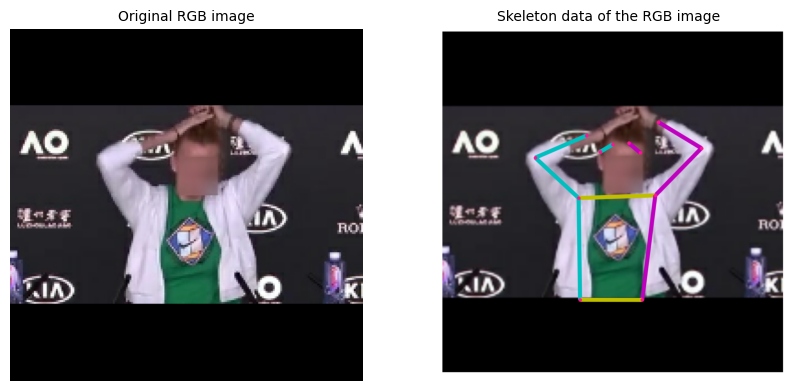

In [40]:
module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
input_size = 192 # the input image size for this version of movenet

def movenet(input_image, module):


    model = module.signatures['serving_default']

    # SavedModel format expects tensor type of int32.
    input_image = tf.cast(input_image, dtype=tf.int32)
    input_image = tf.expand_dims(input_image, 0)
    # Run model inference.
    outputs = model(input_image)
    # Output is a [1, 1, 17, 3] tensor.
    keypoints_with_scores = outputs['output_0'].numpy()
    return keypoints_with_scores


image_path = 'training/13/10048.8.jpg'
image = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image)
image = tf.image.resize_with_pad(image, input_size, input_size)

# Run model inference.
keypoints_with_scores = movenet(image, module)
skeleton = keypoints_with_scores
skeleton[skeleton[:, :, :, 2] < 0.3] = 0

# Visualize the predictions with image.
display_image = tf.expand_dims(image, axis=0)
display_image = tf.cast(tf.image.resize_with_pad(
    display_image, 1280, 1280), dtype=tf.int32)
output_overlay = draw_prediction_on_image(
    np.squeeze(display_image.numpy(), axis=0), skeleton)

plt.figure(figsize=(10, 5))
plt.subplot(1,2,2)
plt.imshow(output_overlay)
plt.title("Skeleton data of the RGB image", fontsize=10)
_ = plt.axis('off')
plt.subplot(1,2,1)
plt.imshow(image/255)
plt.title("Original RGB image", fontsize=10)
_ = plt.axis('off')
plt.show()


Commented out code for creating skeleton data for the training (needed to run only once as the datasets are then saved)

In [5]:


"""skeleton_list_train = []
i = 0
for input_image, label in train_ds:
    # Run model inference.
    keypoints_with_scores = movenet(input_image, module)
    skeleton = keypoints_with_scores
    skeleton[skeleton[:, :, :, 2] < 0.3] = 0

    skeleton_list_train.append(skeleton.flatten())
    i += 1
    print(i)

skeleton_list_val = []
i = 0
for input_image, label in val_ds:
    # Run model inference.
    keypoints_with_scores = movenet(input_image, module)
    skeleton = keypoints_with_scores
    skeleton[skeleton[:, :, :, 2] < 0.3] = 0

    skeleton_list_val.append(skeleton.flatten())
    i += 1
    print(i)
"""





'skeleton_list_train = []\ni = 0\nfor input_image, label in train_ds:\n    # Run model inference.\n    keypoints_with_scores = movenet(input_image, module)\n    skeleton = keypoints_with_scores\n    skeleton[skeleton[:, :, :, 2] < 0.3] = 0\n\n    skeleton_list_train.append(skeleton.flatten())\n    i += 1\n    print(i)\n\nskeleton_list_val = []\ni = 0\nfor input_image, label in val_ds:\n    # Run model inference.\n    keypoints_with_scores = movenet(input_image, module)\n    skeleton = keypoints_with_scores\n    skeleton[skeleton[:, :, :, 2] < 0.3] = 0\n\n    skeleton_list_val.append(skeleton.flatten())\n    i += 1\n    print(i)\n'

In [6]:
#skeleton_train_ds = tf.data.Dataset.from_tensor_slices(skeleton_list_train)
#skeleton_val_ds = tf.data.Dataset.from_tensor_slices(skeleton_list_val)

#skeleton_train_ds.save("skeleton_data/train")
#skeleton_val_ds.save("skeleton_data/val")

Load skeleton data if it's saved, otherwise run the codes above

In [7]:
skeleton_train_ds = tf.data.Dataset.load("skeleton_data/train")
skeleton_val_ds = tf.data.Dataset.load("skeleton_data/val")

Combining the skeleton and image datasets into a multimodal dataset

In [8]:
def make_multimodal_dataset(image_and_label, skeleton):
    image, label = image_and_label
    #skeleton = tf.expand_dims(skeleton, 0)
    return (image, skeleton), label


In [9]:
train_ds = tf.data.Dataset.zip(train_ds, skeleton_train_ds)
train_ds = train_ds.map(make_multimodal_dataset)
val_ds = tf.data.Dataset.zip(val_ds, skeleton_val_ds)
val_ds = val_ds.map(make_multimodal_dataset)

train_ds = train_ds.batch(256)
val_ds = val_ds.batch(256)
print(train_ds.element_spec)

((TensorSpec(shape=(None, 192, 192, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 51), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 32), dtype=tf.float32, name=None))


Define the CNN side of the multimodal model

In [10]:
input_shape = (input_size, input_size, 3)
base_model = tf.keras.applications.EfficientNetV2B0(
    weights="imagenet",
    include_top=False,
    input_shape=input_shape,
    include_preprocessing=True,
)
base_model.trainable = False

cnn_model = models.Sequential(
    [
        layers.Input(shape=input_shape),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        layers.Dense(
            256,
            activation="relu",
            kernel_regularizer=tf.keras.regularizers.l1(0.0001),
            kernel_initializer="lecun_uniform",
        ),
        layers.Dropout(0.5),
        layers.Dense(
            128,
            activation="relu",
            kernel_regularizer=tf.keras.regularizers.l1(0.0001),
            kernel_initializer="lecun_uniform",
        ),
    ],
    name="Transfered_Efficient"
)
cnn_model.summary()

Model: "Transfered_Efficient"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)  │ (None, 6, 6, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,280,144 (23.96 MB)

 Trainable params: 360,832 (1.38 MB)

 Non-trainable params: 5,919,312 (22.58 MB)

Define the dense neural network for the skeleton data point inputs

In [11]:
skeleton = skeleton_train_ds.take(1)

skeleton_shape = skeleton.element_spec.shape
dense_model = models.Sequential(
    [
        layers.Input(shape=skeleton_shape),

        layers.Dense(1024, 
                     activation="relu",
                    kernel_regularizer=tf.keras.regularizers.l1(0.0001),
                    kernel_initializer="lecun_uniform"),
        layers.Dense(512, 
                     activation="relu",
                    kernel_regularizer=tf.keras.regularizers.l1(0.0001),
                    kernel_initializer="lecun_uniform"),
        layers.Dense(
            256,
            activation="relu",
            kernel_regularizer=tf.keras.regularizers.l1(0.0001),
            kernel_initializer="lecun_uniform",
        )
    ],
    name="skeleton_dense"
)
dense_model.summary()

Model: "skeleton_dense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 1024)           │        53,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 709,376 (2.71 MB)

 Trainable params: 709,376 (2.71 MB)

 Non-trainable params: 0 (0.00 B)

Acquire shapes of inputs etc. and cache the datasets

In [12]:



for (example_imgs, example_labels), example_skeleton in train_ds.take(1):
    print(example_imgs.shape)
    print(example_labels.shape)
    print(example_skeleton.shape)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

input_shape = example_imgs.shape[1:]
print("Input shape:", input_shape)
num_labels = len(label_names)
print(num_labels)

(256, 192, 192, 3)
(256, 51)
(256, 32)
Input shape: (192, 192, 3)
32


2024-03-30 00:22:14.277314: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Combine the CNN and dense models into a multimodal model

In [13]:
def MultimodalModel(num_labels, dense_model, cnn_model):
    image_input = layers.Input(shape=input_shape)
    skeleton_input = layers.Input(shape=skeleton_shape)

    cnn_output = cnn_model(image_input)
    skeleton_output = dense_model(skeleton_input)

    concat = layers.Concatenate()([cnn_output, skeleton_output])
    dense_out = layers.Dense(128, activation="relu")(concat)
    model_output = layers.Dense(num_labels, activation="softmax")(dense_out)
    return models.Model([image_input, skeleton_input], model_output)

In [14]:
mm_model = MultimodalModel(32, dense_model, cnn_model)

mm_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 192, 192,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 51)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Transfered_Efficie… │ (None, 128)       │  6,280,144 │ input_layer_3[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ skeleton_dense      │ (None, 256)       │    709,376 │ input_layer_4[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 384)       │          0 │ Transfered_Effic… │
│ (Concatenate)       │                   │            │ skeleton_dense[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │     49,280 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 32)        │      4,128 │ dense_5[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,042,928 (26.87 MB)

 Trainable params: 1,123,616 (4.29 MB)

 Non-trainable params: 5,919,312 (22.58 MB)

Train the multimodal model

In [16]:


train = True
model_name = "mm_model2"
n_epochs = 20
if train:

    LOSS = tf.keras.losses.CategoricalCrossentropy()
    OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=True)

    mm_model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=["accuracy"])

    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=4, verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=2, verbose=1
        ),
    ]

    start = time.time()
    history = mm_model.fit(
        train_ds,
        epochs=n_epochs,
        validation_data=val_ds,
        callbacks=callbacks,
    )
    end = time.time()

    print("It took {} minutes to train Keras model".format((end - start) / 60.0))

    mm_model.save("models/" + model_name + ".keras") # Save the whole keras model
    mm_model.save_weights("models/mm_model2_weights_only.weights.h5") # Save only weights
    # Only weights are used in the inference as there seems 
    # to be a bug regarding loading the whole keras models
    

Epoch 1/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 458s 2s/step - accuracy: 0.3173 - loss: 2.8878 - val_accuracy: 0.3872 - val_loss: 2.3689 - learning_rate: 0.0010
Epoch 2/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 447s 2s/step - accuracy: 0.3482 - loss: 2.4848 - val_accuracy: 0.4049 - val_loss: 2.2855 - learning_rate: 0.0010
Epoch 3/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 451s 2s/step - accuracy: 0.3654 - loss: 2.4178 - val_accuracy: 0.4236 - val_loss: 2.2089 - learning_rate: 0.0010
Epoch 4/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 434s 2s/step - accuracy: 0.3730 - loss: 2.3779 - val_accuracy: 0.4265 - val_loss: 2.1689 - learning_rate: 0.0010
Epoch 5/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 417s 2s/step - accuracy: 0.3789 - loss: 2.3431 - val_accuracy: 0.4330 - val_loss: 2.1604 - learning_rate: 0.0010
Epoch 6/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 416s 2s/step - accuracy: 0.3840 - loss: 2.3320 - val_accuracy: 0.4475 - val_loss: 2.1461 - learning_rate: 0.0010
Epoch 7/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 415s 2s/step - accuracy: 0.3881 - loss: 2.

Plot the training process information

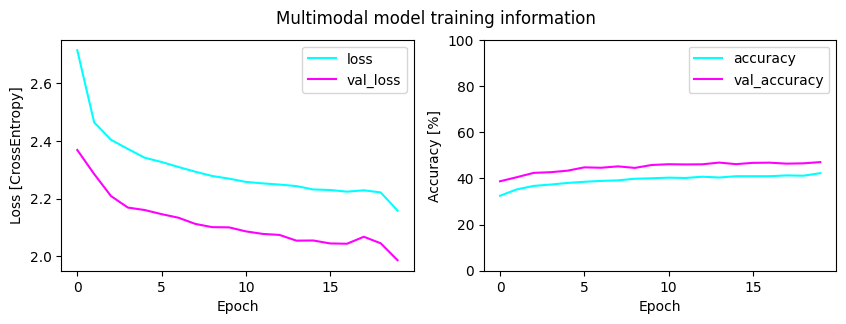

In [42]:
metrics = history.history
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
loss = metrics["loss"]
val_loss = metrics["val_loss"]
axes[0].plot(history.epoch, loss, "cyan", val_loss, "magenta")
axes[0].legend(["loss", "val_loss"])
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss [CrossEntropy]")

fig.suptitle("Multimodal model training information")

axes[1].plot(
    history.epoch,
    100 * np.array(metrics["accuracy"]),
    "cyan",
    100 * np.array(metrics["val_accuracy"]),
    "magenta",
)
axes[1].legend(["accuracy", "val_accuracy"])
axes[1].set_ylim([0, 100])
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy [%]")

plt.show()